<a id='top2'></a>
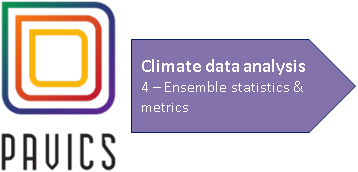

PAVICS ensemble functionalities rely on the <a href="https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html" target="_blank">xclim ensembles</a> module. Ensembles are an important aspect of climate change studies due to various sources of uncertainty in future climate projections and the associated need of their robust incorporation when attempting to produce actionable climate change information. This fourth tutorial will present PAVICS tools for ensemble dataset creation, statistics and metrics accessing output netcdf files created in the previous tutorial on climate indicators. 

This tutorial outlines steps for:

* [Ensemble dataset creation](#create_ens)
* [Ensemble statistics](#ens_stat)
* [Ensemble robustness](#ens_metric)

<div class="alert alert-info"> <strong>Info!</strong> This notebook accesses files created in tutorial 3. Be sure to run the <strong>advanced</strong> section of the <strong>climate indicator calculation</strong> tutorial before beginning.
</div>
<div class="alert alert-info">Advanced topics not covered by this tutorial : <a href="https://xclim.readthedocs.io/en/stable/notebooks/ensembles-advanced.html#" target="_blank">Ensemble reduction</a>.

To conserve any modifications to tutorial notebooks in the PAVICS JupyterLab they need to be copied into your <a href=#workspace>writable-workspace</a> directory.    
</div>

<a id='create_ens'></a>

## Ensemble dataset creation
The ensembles module allows us to easily concatenate multiple netcdf outputs into a single logical dataset via [`create_ensemble`](https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#create_ensemble). We will re-use the output netcdf files from  the previous tutorial's advanced section, where we used a relatively simple workflow to calculate climate indicators on all (n=22) simulations in the `cb-oura-1.0` ensemble.  Note the additional data dimension `realization` which is created.

*[return to top of page](#top2)*

<xarray.Dataset>
Dimensions:        (realization: 11, time: 525, lat: 18, lon: 44)
Coordinates:
  * lat            (lat) float32 49.29 49.21 49.12 49.04 ... 48.04 47.96 47.87
  * lon            (lon) float32 -67.71 -67.63 -67.55 ... -64.3 -64.21 -64.13
  * time           (time) object 1969-12-01 00:00:00 ... 2100-12-01 00:00:00
  * realization    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tx_days_above  (realization, time, lat, lon) float64 dask.array<chunksize=(1, 525, 18, 44), meta=np.ndarray>
Attributes: (12/27)
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Os...
    driving_experiment:         historical,rcp45
    ...                         ...
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC
    crs:                        EPSG:4326

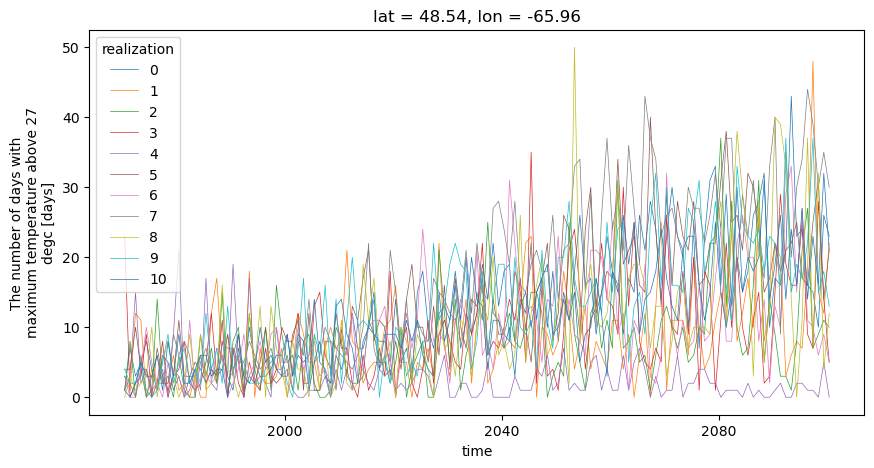

In [1]:
# NBVAL_IGNORE_OUTPUT

import logging
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
from clisops.core import subset
from xclim import ensembles as xens

logging.getLogger().disabled = True
warnings.simplefilter("ignore")
output = "/notebook_dir/writable-workspace/tmp/tutorial3/output"

infolder = Path(output)

# Create a list of rcp 4.5 files  (n=11)
ncfiles = [d for d in infolder.glob("tx_days_above*QS-DEC*rcp45*.nc")]


# Create an ensemble dataset from the 11 simulations
ds_ens = xens.create_ensemble(ncfiles)
display(ds_ens)

# Plot time series of single grid point
lon = -66
lat = 48.5

ds1 = subset.subset_gridpoint(ds_ens, lon=lon, lat=lat)
#  plot summer season
ds1.tx_days_above.sel(time=ds1["time.season"] == "JJA").plot.line(
    figsize=(10, 5), x="time", linewidth=0.5
)
# plt.title('RCP 4.5 individuals runs : ')
display()

___
<a id='ens_stat'></a>
### Ensemble statistics
We can now employ functions for calculating statistics between realizations including calculating <a href="https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#Ensemble-percentiles" target="_blank">ensemble percentiles</a> as well as <a href="https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#Ensemble-statistics" target="_blank">ensemble mean, standard-deviation, maximum & minimum.</a>

<div class="alert alert-info">
<strong>Note : </strong> It is critical to retain all ensemble realizations throughout data treatment steps when creating a new type of summary output (for example annual spatial-means, or 30 year climate normals) such that the final step is the calculation of ensemble percentiles (or mean, min, max) between realizations.  In general one should try to remember that the mean of percentile (or min, max) values does not equal the percentile (or min, max) of the mean conditions.</div>

*[return to top of page](#top2)*

<xarray.Dataset>
Dimensions:        (lat: 18, lon: 44, time: 525, percentiles: 3)
Coordinates:
  * lat            (lat) float32 49.29 49.21 49.12 49.04 ... 48.04 47.96 47.87
  * lon            (lon) float32 -67.71 -67.63 -67.55 ... -64.3 -64.21 -64.13
  * time           (time) object 1969-12-01 00:00:00 ... 2100-12-01 00:00:00
  * percentiles    (percentiles) int64 10 50 90
Data variables:
    tx_days_above  (time, lat, lon, percentiles) float64 dask.array<chunksize=(525, 18, 44, 3), meta=np.ndarray>
Attributes: (12/32)
    units:                      days
    cell_methods:                time: sum over days
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    standard_name:              number_of_days_with_air_temperature_above_thr...
    long_name:                  The number of days with maximum temperature a...
    description:                Seasonal number of days where daily maximum t...
    ...                         ...
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC
    crs:                        EPSG:4326

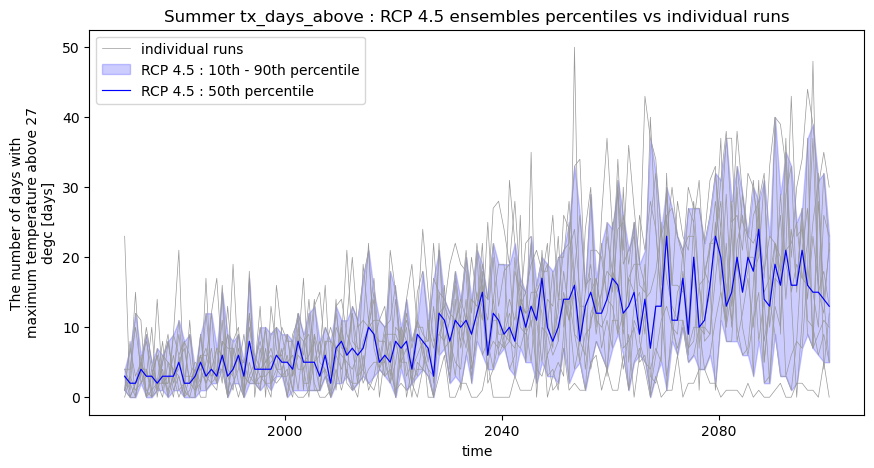

In [2]:
# NBVAL_IGNORE_OUTPUT

# Calculate percentiles
ds_perc = xens.ensemble_percentiles(ds_ens, values=[10, 50, 90], split=False)
display(ds_perc)

# compare with indiviudual runs
sel1 = ds1.tx_days_above.sel(time=ds1["time.season"] == "JJA")
sel1.plot.line(
    label="individual runs",
    color=[0.6, 0.6, 0.6],
    figsize=(10, 5),
    x="time",
    linewidth=0.5,
)

perc1 = subset.subset_gridpoint(ds_perc, lon=lon, lat=lat).tx_days_above.sel(
    time=ds_perc["time.season"] == "JJA"
)

# plot uncertainty bounds
plt.fill_between(
    color="b",
    label="RCP 4.5 : 10th - 90th percentile",
    x=perc1.time.values,
    y1=perc1.sel(percentiles=10),
    y2=perc1.sel(percentiles=90),
    alpha=0.2,
)
# plot median
perc1.sel(percentiles=50).plot(
    label="RCP 4.5 : 50th percentile",
    color="b",
    linewidth=0.85,
)

# combine legend entries for individual runs
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title("Summer tx_days_above : RCP 4.5 ensembles percentiles vs individual runs")
display()

___

<a id='ens_metric'></a>
### Ensemble robustness metrics
PAVICS <a href="https://xclim.readthedocs.io/en/stable/api.html#ensemble-robustness-metrics" target="_blank">robustness metrics</a> can be used to estimate the confidence of the climate change signal. Currently a small number of metrics are implemented based on the IPCC's fifth assessment report : <a href="https://www.ipcc.ch/site/assets/uploads/2018/02/WG1AR5_Chapter12_FINAL.pdf" target="_blank">IPCC AR5 WG1 - chapter 12</a> (see box 12.1) 

In the example below we use the `change_significance` method to examine the fraction of ensemble members that show a significant change between future and reference 30 year periods (left panel) and additionally the fraction of those members with significant future change that indicate an increase in future values (right panel)

*[return to top of page](#top2)*

AttributeError: 'Dataset' object has no attribute 'description'

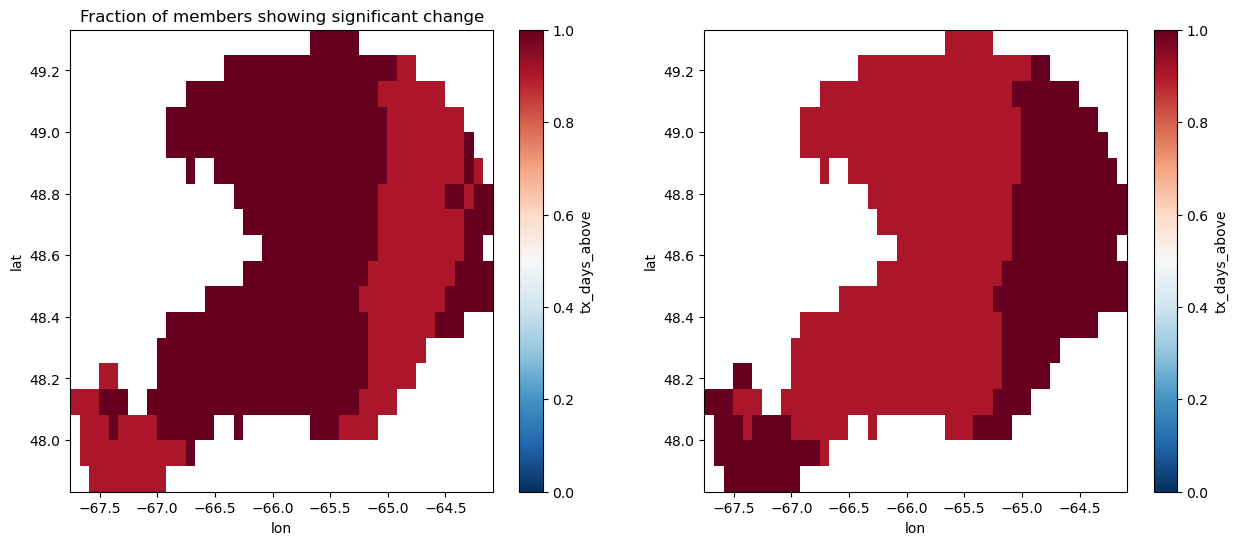

In [3]:
fut = ds_ens.sel(time=slice("2071", "2100")).chunk(dict(realization=-1))
ref = ds_ens.sel(time=slice("1981", "2010")).chunk(dict(realization=-1))

chng_f, pos_f = xens.change_significance(
    fut.sel(time=fut["time.season"] == "JJA"),
    ref.sel(time=ref["time.season"] == "JJA"),
    test="ttest",
)
plt.figure(
    figsize=(15, 6),
)

plt.subplot(1, 2, 1)
chng_f.tx_days_above.plot(cmap="RdBu_r", vmin=0, vmax=1)

plt.title(chng_f.description.split(".")[0])

plt.subplot(1, 2, 2)
pos_f.tx_days_above.plot(cmap="RdBu_r", vmin=0, vmax=1)
plt.title(pos_f.description.split(".")[0])

display()

___
### Notes
<a id='workspace'></a>

<div class="alert alert-info"><strong>Info! writeable-workspace location.</strong> To conserve any modifications and to avoid permission errors for notebooks which write output to disk it is necessary to copy tutorial notebooks from the "pavics-homepage" folder to a location within your "writeable-workspace"
</div>

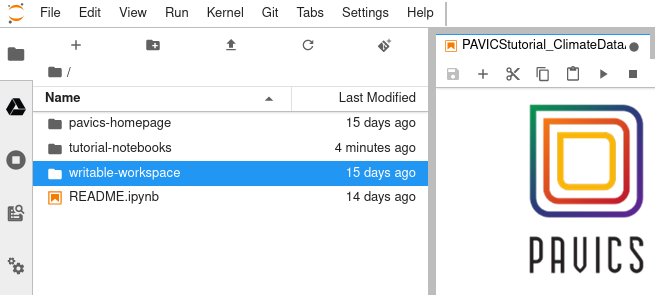

*[return to top of page](#top2)*